In [1]:
import librosa
import numpy as np

def extract_features(file_name):
    try:
        y, sr = librosa.load(file_name, res_type='kaiser_fast') 
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=60)
        mfccScaled = np.mean(mfcc.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None 
     
    return mfccScaled

In [2]:
# Load various imports 
import pandas as pd
import os
import librosa

# Set the path to the full UrbanSound dataset 
generalSoundPath = 'Audio-Classification/General-Sounds/'
legalVoicePath = 'Audio-Classification/User-Voices/Legal-Voices/'
illegalVoicePath = 'Audio-Classification/User-Voices/Illegal-Voices/'

features = []

def fetchDataset(path, class_label):
    for dirpath, dirnames, filenames in os.walk(path):
        for filename in filenames:
            file_name = os.path.join(dirpath, filename)
            data = extract_features(file_name)
            features.append([data, class_label])
            
fetchDataset(generalSoundPath, 'General Sound')
fetchDataset(legalVoicePath, 'Legal Voice')
fetchDataset(illegalVoicePath, 'Illegal Voice')

# for dirpath, dirnames, filenames in os.walk(generalSoundPath):
#     for filename in filenames:
#         file_name = os.path.join(dirpath, filename)
        
#         class_label = 'General Sound'
#         data = extract_features(file_name)

#         features.append([data, class_label])
        
# for dirpath, dirnames, filenames in os.walk(legalVoicePath):
#     for filename in filenames:
#         file_name = os.path.join(dirpath, filename)
        
#         class_label = 'Legal Voice'
#         data = extract_features(file_name)

#         features.append([data, class_label])
        
# for dirpath, dirnames, filenames in os.walk(illegalVoicePath):
#     for filename in filenames:
#         file_name = os.path.join(dirpath, filename)
        
#         class_label = 'Illegal Voice'
#         data = extract_features(file_name)

#         features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from', len(featuresdf), 'files')

Finished feature extraction from 7361 files


In [3]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

In [4]:
# split the dataset 
from sklearn.model_selection import train_test_split 
from collections import Counter

x_temp, x_test, y_temp, y_test = train_test_split(X, yy, test_size=0.2, random_state = 0)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.25, random_state = 0)

print(Counter(np.argmax(y_train, axis=1)))
print(Counter(np.argmax(y_val, axis=1)))
print(Counter(np.argmax(y_test, axis=1)))

Counter({2: 1858, 0: 1530, 1: 1028})
Counter({2: 609, 0: 519, 1: 344})
Counter({2: 614, 0: 503, 1: 356})


In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation#, Flatten

# Construct model 
model = Sequential()

model.add(Dense(256, input_shape=x_train[0].shape))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(yy.shape[1]))
model.add(Activation('softmax'))

In [6]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [7]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100 * score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               15616     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 7

In [8]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_mlp.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_val, y_val), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
138/138 [==============================] - 5s 9ms/step - loss: 8.3987 - accuracy: 0.4534 - val_loss: 0.7836 - val_accuracy: 0.6304

Epoch 00001: val_loss improved from inf to 0.78365, saving model to saved_models\weights.best.basic_mlp.hdf5
Epoch 2/100
138/138 [==============================] - 1s 5ms/step - loss: 1.7293 - accuracy: 0.5240 - val_loss: 0.9189 - val_accuracy: 0.5897

Epoch 00002: val_loss did not improve from 0.78365
Epoch 3/100
138/138 [==============================] - 1s 5ms/step - loss: 1.0287 - accuracy: 0.5661 - val_loss: 0.8936 - val_accuracy: 0.5938

Epoch 00003: val_loss did not improve from 0.78365
Epoch 4/100
138/138 [==============================] - 1s 5ms/step - loss: 0.9330 - accuracy: 0.5870 - val_loss: 0.8260 - val_accuracy: 0.6284

Epoch 00004: val_loss did not improve from 0.78365
Epoch 5/100
138/138 [==============================] - 1s 6ms/step - loss: 0.8287 - accuracy: 0.6304 - val_loss: 0.7364 - val_accuracy: 0.7058

Epoch 00005: val_l

138/138 [==============================] - 1s 5ms/step - loss: 0.2691 - accuracy: 0.8875 - val_loss: 0.2314 - val_accuracy: 0.9090

Epoch 00035: val_loss did not improve from 0.22825
Epoch 36/100
138/138 [==============================] - 1s 7ms/step - loss: 0.2597 - accuracy: 0.8947 - val_loss: 0.2271 - val_accuracy: 0.9144

Epoch 00036: val_loss improved from 0.22825 to 0.22713, saving model to saved_models\weights.best.basic_mlp.hdf5
Epoch 37/100
138/138 [==============================] - 1s 5ms/step - loss: 0.2598 - accuracy: 0.8958 - val_loss: 0.2289 - val_accuracy: 0.9192

Epoch 00037: val_loss did not improve from 0.22713
Epoch 38/100
138/138 [==============================] - 1s 5ms/step - loss: 0.2617 - accuracy: 0.8979 - val_loss: 0.2377 - val_accuracy: 0.9008

Epoch 00038: val_loss did not improve from 0.22713
Epoch 39/100
138/138 [==============================] - 1s 5ms/step - loss: 0.2453 - accuracy: 0.9065 - val_loss: 0.2094 - val_accuracy: 0.9239

Epoch 00039: val_loss 

138/138 [==============================] - 1s 6ms/step - loss: 0.1596 - accuracy: 0.9380 - val_loss: 0.2308 - val_accuracy: 0.9287

Epoch 00075: val_loss did not improve from 0.18735
Epoch 76/100
138/138 [==============================] - 1s 5ms/step - loss: 0.1511 - accuracy: 0.9488 - val_loss: 0.2134 - val_accuracy: 0.9334

Epoch 00076: val_loss did not improve from 0.18735
Epoch 77/100
138/138 [==============================] - 1s 5ms/step - loss: 0.1471 - accuracy: 0.9472 - val_loss: 0.1988 - val_accuracy: 0.9402

Epoch 00077: val_loss did not improve from 0.18735
Epoch 78/100
138/138 [==============================] - 1s 5ms/step - loss: 0.1514 - accuracy: 0.9463 - val_loss: 0.1922 - val_accuracy: 0.9416

Epoch 00078: val_loss did not improve from 0.18735
Epoch 79/100
138/138 [==============================] - 1s 6ms/step - loss: 0.1628 - accuracy: 0.9366 - val_loss: 0.2124 - val_accuracy: 0.9334

Epoch 00079: val_loss did not improve from 0.18735
Epoch 80/100
138/138 [===========

In [9]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_val, y_val, verbose=0)
print("Validation Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.97826087474823
Validation Accuracy:  0.9375
Testing Accuracy:  0.9463679790496826


['General Sound' 'Illegal Voice' 'Legal Voice']


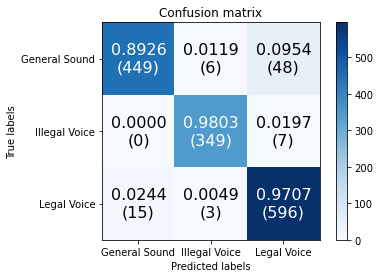

               precision    recall  f1-score   support

General Sound       0.97      0.89      0.93       503
Illegal Voice       0.97      0.98      0.98       356
  Legal Voice       0.92      0.97      0.94       614

     accuracy                           0.95      1473
    macro avg       0.95      0.95      0.95      1473
 weighted avg       0.95      0.95      0.95      1473



In [10]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from matplotlib.colors import Normalize

print(le.classes_)

y_true = np.argmax(y_test, axis=-1)
y_pred = np.argmax(model.predict(x_test), axis=-1)
confusion_mat = confusion_matrix(y_true, y_pred)
ratio_mat = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis]

plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
ticks = np.arange(3)
plt.xticks(ticks, le.classes_)
plt.yticks(ticks, le.classes_)
thresh = confusion_mat.max() / 2
for i in range(3):
    for j in range(3):
        plt.text(j, i, "{:0.4f}\n({})".format(ratio_mat[i, j], confusion_mat[i, j]),
                 ha="center",
                 va="center",
                 color="white" if confusion_mat[i, j] > thresh else "black",
                 fontsize=16)
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.show()

print(classification_report(y_true, y_pred, target_names=le.classes_))

In [11]:
def print_prediction(file_name):
    prediction_feature = np.expand_dims(extract_features(file_name), axis=0)
    predicted_proba_vector = model.predict(prediction_feature)
    
    predicted_class_vector = np.argmax(predicted_proba_vector, axis=-1)
    predicted_class = le.inverse_transform(predicted_class_vector) 
    print("The predicted class is:", predicted_class[0], '\n') 

    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)): 
        print(le.classes_[i], "\t\t : ", format(predicted_proba[i], '.32f') )

In [12]:
from IPython.display import Audio 
from IPython.core.display import display

# Legal
filename = 'V-YT-PSY-006051.wav'

display(Audio(filename, autoplay=True))
print_prediction(filename)

The predicted class is: Illegal Voice 

General Sound 		 :  0.14348533749580383300781250000000
Illegal Voice 		 :  0.79454761743545532226562500000000
Legal Voice 		 :  0.06196706742048263549804687500000
